## Libraries

In [1]:
# Essentials
import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from torch.nn import functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from umap import UMAP

# User libraries
from BatchEffectDataLoader import DataPreprocess, DataTransform, ABaCoDataLoader, one_hot_encoding, class_to_int
from BatchEffectCorrection import correctCombat
from BatchEffectPlots import plotPCA, plotPCoA
from BatchEffectMetrics import kBET, iLISI, cLISI, ARI, ASW
from MetaABaCo import (
    NormalPrior,
    NormalEncoder,
    MoGPrior,
    MoGEncoder,
    ZINBDecoder,
    VAE,
    train,
    MixtureOfGaussians,
    BatchDiscriminator,
    BiologicalConservationClassifier,
    train_abaco,
    contour_plot,
    GeneAttention,
    AttentionMoGEncoder,
    AttentionZINBDecoder,
    VampPriorVAE,
    VampPriorMixtureVAE,
)

>> clustergrammer2 backend version 0.18.0


## Dataloading

In [4]:
input_size = 567
d_z = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path = "data/dataset_ad.csv"
batch_label = "batch"
sample_label = "sample"
exp_label = "trt"

data = DataPreprocess(
    path,
    factors=[sample_label, batch_label, exp_label]
)

plotPCoA(data, 
         sample_label=sample_label,
         batch_label=batch_label,
         experiment_label=exp_label,
         method="aitchison")

In [5]:
# train DataLoader: [samples, ohe_batch]
train_dataloader = DataLoader(
    TensorDataset(
        torch.tensor(data.select_dtypes(include="number").values, dtype=torch.float32), # samples
        one_hot_encoding(data[batch_label])[0], # one hot encoded batch information
        one_hot_encoding(data[exp_label])[0], #one hot encoded biological information
    ),
    batch_size=128,
)

## ABaCo with VMM

In [64]:
K = 2
n_batches = 5


# Encoder
mog_encoder_net = nn.Sequential(
    nn.Linear(input_size, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 258),
    nn.ReLU(),
    nn.Linear(258, K * (2 * d_z + 1)),
)

# Decoder
zinb_decoder_net = nn.Sequential(
    nn.Linear(d_z, 258),
    nn.ReLU(),
    nn.Linear(258, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 3 * input_size),
)

# Batch discriminator
batch_disc_net = nn.Sequential(
    nn.Linear(d_z, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, n_batches),
)

# Biological classifier
bio_class_net = nn.Sequential(
    nn.Linear(d_z, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, K),
)

# Defining VMM model
encoder = MoGEncoder(mog_encoder_net, n_comp=K)
decoder = ZINBDecoder(zinb_decoder_net)
vae_model = VampPriorMixtureVAE(
    encoder=encoder,
    decoder=decoder,
    input_dim=input_size,
    n_comps=K,
    d_z=d_z,
    beta=10.0,
    data_loader=train_dataloader,
).to(device)

# Defining batch discriminator
discriminator = BatchDiscriminator(batch_disc_net).to(device)

bio_classifier = BiologicalConservationClassifier(bio_class_net).to(device)

# Optimizers
adv_optim = torch.optim.Adam(vae_model.encoder.parameters(), lr=1e-4, weight_decay=1e-5)

vae_optim = torch.optim.Adam(
    [
        {"params": vae_model.encoder.parameters()},
        {"params": vae_model.decoder.parameters()},
        {"params": [vae_model.u]},
    ],
    lr=1e-3,
)

disc_optim = torch.optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=1e-5)
bio_optim = torch.optim.Adam([
        {"params": bio_classifier.parameters()}, 
        {"params": vae_model.encoder.parameters()},
    ], lr=1e-3, weight_decay=1e-5)

In [65]:
epochs = 500
train_abaco(
    vae=vae_model,
    vae_optim=vae_optim,
    discriminator=discriminator,
    disc_optim=disc_optim,
    adv_optim=adv_optim,
    bio_classifier=bio_classifier,
    bio_optim=bio_optim,
    data_loader=train_dataloader,
    epochs=epochs,
    device=device,
    w_disc=1.0,
    w_adv=10.0,
    w_elbo=1.0,
    w_bio=10.0,
    disc_loss_type="CrossEntropy",
)

Training: 100%|██████████| 500/500 [00:09<00:00, 54.95it/s, adv_loss=-15.5092, bio_loss=0.0564, disc_loss=1.5519, epoch=500/500, vae_loss=892.3467]  


In [66]:
recon_data = []

for x in train_dataloader:
    x = x[0].to(device)
    encoded = vae_model.encoder(x)
    z = encoded.rsample()
    decoded = vae_model.decoder(z)
    recon = decoded.sample()
    recon_data.append(recon)

np_recon_data = np.vstack([t.detach().cpu().numpy() for t in recon_data])

In [67]:
otu_corrected_pd = pd.concat(
    [
        pd.DataFrame(np_recon_data, index=data.index, columns=data.select_dtypes("number").columns),
        data[batch_label],
        data[exp_label],
        data[sample_label],
    ],
    axis=1,
)

plotPCoA(
    otu_corrected_pd,
    method="aitchison",
    sample_label=sample_label,
    batch_label=batch_label,
    experiment_label=exp_label,
)

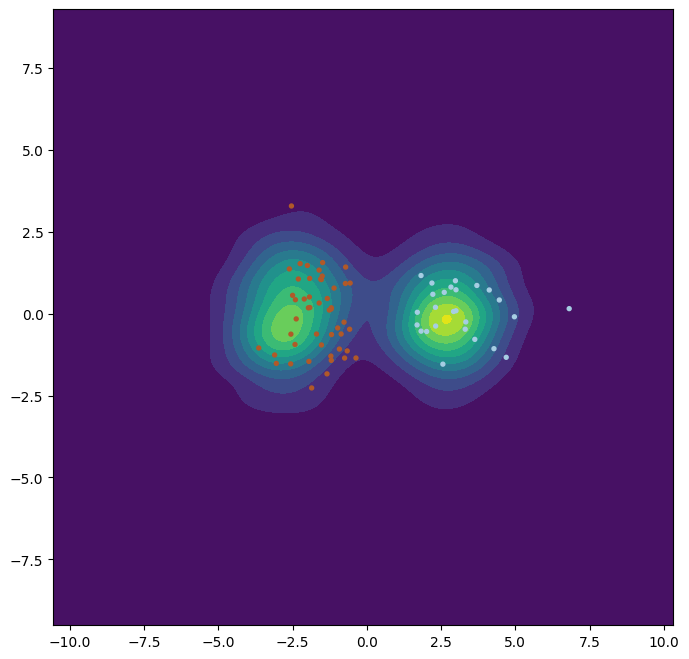

In [68]:
ohe_batch = one_hot_encoding(data[exp_label])[0]

# Get PCA of posterior distribution
z_pca = []
for x in train_dataloader:
    x = x[0].to(device)
    pca = vae_model.pca_posterior(x)
    z_pca.append(pca)

# Plot PCA from sample
z_stacked = np.vstack(z_pca)

# Sample from prior distribtution for countour plot
prior_sample = vae_model.pca_prior(n_samples=1000)

# scatter = plt.scatter(z_stacked[:, 0], z_stacked[:, 1], c=torch.cat(labels).numpy(), cmap='tab10', alpha=0.7)
# cbar = plt.colorbar(scatter, boundaries = np.arange(11)-0.5)
# cbar.set_ticks(np.arange(10))
# cbar.set_ticklabels(np.arange(10))
# cbar.set_label('Label')

# Plot posterior into prior contour surface plot

plt.figure(figsize=(8, 8))
contour = contour_plot(prior_sample, n_levels=10, x_offset=5, y_offset=5, alpha=1)
scatter = plt.scatter(
    z_stacked[:, 0],
    z_stacked[:, 1],
    alpha=1,
    c=ohe_batch.detach().cpu().numpy().argmax(axis=1),
    cmap="Paired",
    s=8,
)

# plt.xlim([-20, 30])
# plt.ylim([-10, 10])

plt.show()